In [1]:
# SPFDM Assignment 1
# Luuk Oudshoorn and Willem-Jan de Voogd
# Fall 2020

In [43]:
import dx
import time
import numpy as np
import pandas as pd
import datetime as dt
from pylab import plt
from glob import glob
from scipy.interpolate import interp1d
%matplotlib inline

Text(0, 0.5, 'Rate (%)')

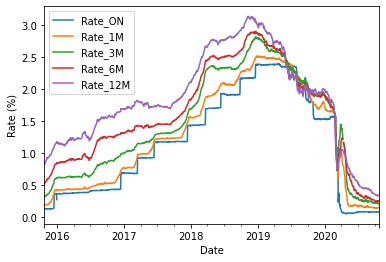

In [44]:
# Load LIBOR Rates
periods = ['ON','1M','3M','6M','12M']
LIBOR = pd.DataFrame()
for period in periods:
    filename = glob('./USD'+period+'*.csv')[0]
    LIBOR_sub = pd.read_csv(filename)
    LIBOR_sub['DATE'] = pd.to_datetime(LIBOR_sub['DATE'])
    LIBOR_sub.columns = ['Date','Rate_'+period]
    LIBOR_sub = LIBOR_sub.set_index('Date')
    LIBOR_sub = LIBOR_sub.replace('.',np.nan)
    LIBOR_sub['Rate_'+period] = LIBOR_sub['Rate_'+period].astype(float)
    LIBOR = pd.concat((LIBOR,LIBOR_sub),axis=1)
LIBOR.plot()
plt.ylabel('Rate (%)')

In [45]:
# Libor rates from ICE
# https://www.theice.com/marketdata/reports/170
#LIBOR = pd.DataFrame({'Name':['Rate_3M','Rate_6M','Rate_12M'],'Rate':[-0.52971,-0.52329,-0.47386]}).set_index('Name')
#LIBOR
# Latest libor rates
# These are annualized interest rates
LIBOR = pd.DataFrame({'Rate':LIBOR.iloc[-1,2:]})
LIBOR

,Rate
Rate_3M,0.21650
Rate_6M,0.24938
Rate_12M,0.33663


In [46]:
# OIS curve, is 0.1% lower than Libor curve assuming fixed spread
# We bootstrap the OIS for quarterly payments
OIS = LIBOR -0.1
OIS

,Rate
Rate_3M,0.11650
Rate_6M,0.14938
Rate_12M,0.23663


In [47]:
# OIS is the first part of the zero curve
zerocurve = pd.DataFrame({'Years':[0.25,0.5,1],'Zero rate':OIS.values.flatten()})
zerocurve

# Since I do not yet understand how to get the 0.75year rate, plug it in manually
zerocurve.loc[3] = [0.75,0.195]

zerocurve = zerocurve.set_index('Years').sort_index()
zerocurve
for i in np.arange(1.25,30.1,0.25):
    zerocurve.loc[i] = np.nan
zerocurve

,Zero rate
Years,
0.25,0.11650
0.50,0.14938
0.75,0.19500
1.00,0.23663
1.25,NaN
...,...
29.00,NaN
29.25,NaN
29.50,NaN


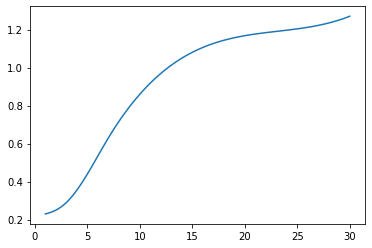

,Swap_Rate
Years,
1.00,0.230000
1.25,0.233570
1.50,0.238008
1.75,0.243443
2.00,0.250000
...,...
29.00,1.250393
29.25,1.254911
29.50,1.259678


In [48]:
# To obtain longer rates we need to bootstrap
# For bootstrapping we also need the swap rates. These are obtained from 
# http://www.interestrateswapstoday.com/swap-rates.html
def read_interp_swaprates():
    swaprates  =  pd.DataFrame({'Name':['1-Year','2-Year','3-Year','5-Year','7-Year','10-Year','30-Year'],'Rate':[0.230,0.25,0.29,0.44,0.63,0.86,1.270]}).set_index('Name')
    swaprates['NMonths'] = [12,24,36,60,84,120,360]
    #We need to interpolate swaprates to get all intermediate values
    to_interpolate = np.arange(12,361,3)
    # We use cubic interpolation as this generates a much smoother curve
    interpolated = interp1d(swaprates['NMonths'],swaprates['Rate'],kind='cubic')(to_interpolate)
    swaprates_interp = pd.DataFrame({'Years':to_interpolate/12,'Swap_Rate':interpolated})
    return swaprates_interp.set_index('Years')
swaprates_interp = read_interp_swaprates()
plt.plot(swaprates_interp.index, swaprates_interp.Swap_Rate)
plt.show()
swaprates_interp

In [49]:
# Having both libor and swap rates we should be able to bootstrap the zero curve

In [50]:
def bootstrap(disc_rates, disc_rates_times,to_calculate, swaprate, duration, payterm):
    """Takes known discounting rates and known swap rate for some times
       and returns the swaprate for an unknown time"""
    # payterm = years between payments
    # discount rates = libor/ois like rates
    # swaprate is the at-par rate for the IRS
    # duration is the number of years of the swap
    
    Npayments = duration / payterm - 1 # because we estimate one
    # We loop through all payments except for the unknown
    swapvalue = 0
    for i,time in enumerate(disc_rates_times):
        if time != duration: # intermediate payouts
            payout = swaprate * payterm
        elif time ==duration: #final payout
            payout = swaprate * payterm + 100
        depreciation = np.exp(-time*disc_rates[i]/100)
        swapvalue += payout * depreciation
    # The swap is now worth par, thus 100. We calculate the rate solving the 
    # missing term
    
    if to_calculate == duration:
        # If we miss the last term, then divide by 100+coupon
        rate = np.log((100-swapvalue)/(swaprate * payterm + 100))/(-to_calculate)
    elif to_calculate != duration:
        # If we search for an intermediate term, divide by coupon
        rate = np.log((100-swapvalue)/(swaprate * payterm))/(-to_calculate)
    return (rate*100)

In [51]:
# Example from Hull
disc_rates = [4,4.5,4.8]
disc_rates_times = [0.5,1,1.5]
to_calculate = 2
swaprate   = 5
duration   = 2
payterm    = 0.5
bootstrap(disc_rates, disc_rates_times,to_calculate, swaprate, duration, payterm)

4.952932701412535

In [52]:
# Inverse problem of Hull; we know 0.5,1,2
disc_rates = [4,4.5,4.95293270]
disc_rates_times = [0.5,1,2]
to_calculate = 1.5
swaprate   = 5
duration   = 2
payterm    = 0.5
bootstrap(disc_rates, disc_rates_times,to_calculate, swaprate, duration, payterm)

4.800000075157118

In [55]:
# We have swap rates for all 3 month periods by interpolation
# Using each swap rate we can now equate the zero yield rate for that period
for years,row in zerocurve.iterrows():
    if (np.isnan(row['Zero rate'])):
        # Unknown rate, bootstrap!
        # Obtain swap rate for this maturity
        swaprate = swaprates_interp.loc[years].Swap_Rate
        known_rates = zerocurve.loc[:years-0.25]
        zerorate = bootstrap(known_rates.values,known_rates.index,years,
                             swaprate,years,0.25)
        zerocurve.loc[years] = zerorate


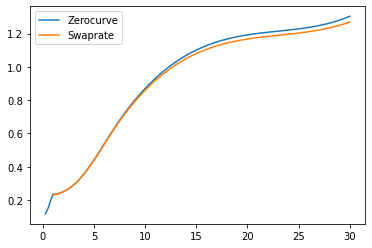

In [60]:
plt.plot(zerocurve.index, zerocurve.values,label='Zerocurve')
plt.plot(swaprates_interp.index, swaprates_interp.Swap_Rate,label='Swaprate')
plt.legend()

In [126]:
class zero_curve():
    def __init__(self):
        libor3,libor6,libor12 = LIBOR.values
        self.libor3  = libor3[0]/100
        self.libor6  = libor6[0]/100
        self.libor12 = libor12[0]/100
        self.__9months__()
        return
    
    def __9months__(self):
        """Consider bond selling at par"""
        npayments = 4
        nyears    = 1
        interval  = nyears / npayments
        rateperyear = swaprates.loc['1-Year'].values[0]/100
        bondvalue   = 100
        rates = [self.libor3,self.libor6,self.libor12]
        value = 0
        for i,time in enumerate([3,6,12]):
            if time is not 12:
                payout = rateperyear * bondvalue * interval
            else:
                payout = bondvalue+rateperyear * bondvalue * interval
            value += (payout * np.exp(-time/12 * rates[i]))
        r9 = -4/3*np.log(4/(bondvalue*rateperyear)*(bondvalue-value))
        print(r9)
        
    
    def __bootstrap__(init):
        """Loop through all available swaps to get the zero rate of that period"""
        for i,nyears in enumerate([2,3,5,7,10,30]):
            # Obtain the swap rate for this period
            swaprate = swaprates.loc[nyears+'-Year'].value/100
            # The swaprate is the fixed lag that is received each quarter
            # The rate we need is the one making the bond worth par
            nmonths = nyears*4
            
            
            
zc = zero_curve()

nan


<>:20: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:20: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-126-97578213f237>:20: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if time is not 12:
<ipython-input-126-97578213f237>:25: RuntimeWarning: invalid value encountered in log
  r9 = -4/3*np.log(4/(bondvalue*rateperyear)*(bondvalue-value))


In [127]:
import pandas as pd
import QuantLib as ql

data = [{'Date': '2020-11-03','3M':0.21650, '1Y': 0.23, '2Y': 0.26, '5Y':  0.46, '7Y': 0.66, '10Y': 0.89, '30Y': 1.31}]

calendar = ql.UnitedStates()
zeros = []
deposits = ['3M']
swaps = ['1Y', '2Y', '5Y', '7Y', '10Y', '30Y']
for row in data:
    # Build Curve for the date
    curve_date = ql.Date(row['Date'][:10], '%Y-%m-%d')
    ql.Settings.instance().evaluationDate = curve_date
    spot_date = calendar.advance(curve_date, 2, ql.Days)
    helpers = ql.RateHelperVector()
    for tenor in deposits:
        index = ql.USDLibor(ql.Period(tenor))
        helpers.append(
            ql.DepositRateHelper(row[tenor] / 100, index)
        )
    for tenor in swaps:
        swap_index = ql.UsdLiborSwapIsdaFixAm(ql.Period(tenor))
        helpers.append(
            ql.SwapRateHelper(row[tenor] / 100, swap_index)
        )
    curve = ql.PiecewiseCubicZero(curve_date, helpers, ql.Actual360())

    # Get Zero Rates
    for tenor in deposits + swaps:
        date = calendar.advance(spot_date, ql.Period(tenor))
        rate = curve.zeroRate(date, ql.Actual360(), ql.Compounded, ql.Annual).rate()
        zeros.append({ 'curve_date': curve_date, 'tenor': tenor, 'zero_rate': rate})

pd.DataFrame(zeros)

,curve_date,tenor,zero_rate
0,"November 3rd, 2020",3M,0.002167
1,"November 3rd, 2020",1Y,0.002269
2,"November 3rd, 2020",2Y,0.002566
3,"November 3rd, 2020",5Y,0.004550
4,"November 3rd, 2020",7Y,0.006562
5,"November 3rd, 2020",10Y,0.008908
6,"November 3rd, 2020",30Y,0.013399
